In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import seaborn

# Some plotting config
seaborn.set(
    context="notebook",
    # style="ticks",
    style="darkgrid",
    font="Times New Roman",
    font_scale=1.5,
)
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
# plt.rcParams["xtick.top"] = True
# plt.rcParams["ytick.right"] = True
# plt.rcParams["xtick.bottom"] = True
# plt.rcParams["ytick.left"] = True
plt.rcParams["mathtext.fontset"] = "cm"

from tqdm.auto import tqdm, trange

from ssptools import evolve_mf_3 as emf3
from limepy import limepy

import numpy as np
import scipy as sp
import pandas as pd
import astropy.units as u
import astropy.constants as const

from binaryshift import BinaryShift
import binaryshift

from fitter import Observations
from fitter import Model

In [2]:
obs = Observations("NGC0104")

In [3]:
theta = [6.62, 0.88, 6.82, 1.33, 1.03, 0.37, 0.01, 3.49, 0.47, 1.18, 2.15, 0.13, 4.42]

In [4]:
model = Model(theta=theta, observations=obs)

/home/peter/anaconda3/envs/gcfit/lib/python3.9/site-packages/ssptools/evolve_mf_3.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  Aj = Nj / self.Pk(alphaj, 1, m1, mto)


In [5]:
model.rhoj

<Quantity [[4.05644323e+01, 4.05644320e+01, 4.05643947e+01, ...,
            2.20188030e-21, 7.22111370e-22, 0.00000000e+00],
           [8.52418934e+01, 8.52418927e+01, 8.52418069e+01, ...,
            3.64983138e-21, 1.19697004e-21, 0.00000000e+00],
           [1.93073119e+02, 1.93073118e+02, 1.93072899e+02, ...,
            5.94913681e-21, 1.95103220e-21, 0.00000000e+00],
           ...,
           [1.19560817e+03, 1.19560813e+03, 1.19560354e+03, ...,
            2.35063761e-23, 7.70896702e-24, 0.00000000e+00],
           [1.52945676e+03, 1.52945670e+03, 1.52945057e+03, ...,
            1.77817822e-23, 5.83157405e-24, 0.00000000e+00],
           [4.75564369e-01, 4.75564353e-01, 4.75562445e-01, ...,
            5.54112783e-27, 1.81722489e-27, 0.00000000e+00]] solMass / pc3>

In [6]:
model.mj[model._single_mask]

<Quantity [0.1185088 , 0.16351011, 0.22559975, 0.31126667, 0.42946386,
           0.5361614 , 0.61588772, 0.70746921, 0.80019379, 0.61588772,
           0.70746921, 0.80019379, 0.91959636, 1.1188027 , 1.40848915,
           3.53796479, 4.45403378, 5.60729631, 7.05916782] solMass>

In [7]:
model.Mj

<Quantity [9.67708882e+03, 1.63135092e+04, 2.73253273e+04, 4.68695790e+04,
           7.81751587e+04, 4.33355794e+04, 5.12435594e+04, 5.76823476e+04,
           5.00603612e+04, 1.60687493e+05, 1.30459796e+05, 2.98747646e+04,
           3.07490105e+04, 6.98248670e+04, 9.61818698e+03, 1.66520599e+01,
           3.11576169e+01, 6.22154453e+01, 1.35825876e+02, 3.00621250e+03,
           2.98104802e+03, 4.94124363e+03, 5.73453657e+03, 5.69718804e+03,
           9.67515609e+03, 6.13755515e+03, 6.00345302e+03, 6.51565659e+03,
           2.92073080e+03, 5.15998036e+03, 3.57292722e+03, 3.29243655e+03,
           1.07663846e+03, 1.14240194e+03, 3.55476335e-01] solMass>

In [8]:
len(model.Mj)

35

In [9]:
model.rhoj[model._single_mask]

<Quantity [[4.05644323e+01, 4.05644320e+01, 4.05643947e+01, ...,
            2.20188030e-21, 7.22111370e-22, 0.00000000e+00],
           [8.52418934e+01, 8.52418927e+01, 8.52418069e+01, ...,
            3.64983138e-21, 1.19697004e-21, 0.00000000e+00],
           [1.93073119e+02, 1.93073118e+02, 1.93072899e+02, ...,
            5.94913681e-21, 1.95103220e-21, 0.00000000e+00],
           ...,
           [3.26229588e+02, 3.26229565e+02, 3.26226774e+02, ...,
            1.43532447e-30, 4.70717819e-31, 0.00000000e+00],
           [9.13157765e+02, 9.13157688e+02, 9.13148426e+02, ...,
            1.79454479e-32, 5.88524931e-33, 0.00000000e+00],
           [2.74868029e+03, 2.74868002e+03, 2.74864696e+03, ...,
            8.15032417e-35, 2.67291694e-35, 0.00000000e+00]] solMass / pc3>

In [10]:
def flatten(t):
    """
    Flatten a nested list
    https://stackoverflow.com/a/952952/13577036
    """
    return [item for sublist in t for item in sublist]

In [11]:
def rescale_densities(model):

    # make copy of density profile, Mj
    rescaled_rhoj = model.rhoj[model._single_mask].copy()
    scaled_Mj = model.Mj[model._single_mask].copy()

    # get binaries
    binaries = flatten(model._binshift.q_values)

    # get isochrone
    isochrone = binaryshift.gcfit.get_isochrone(model)

    # loop through each binary population
    for binary in binaries:

        # find "observed" mass
        observed_mass = (
            binaryshift.gcfit.get_observed_mass(
                isochrone=isochrone, mj=binary.mj, q=binary.q
            )
            << u.Msun
        )

        # find closest mass bin
        closest_idx = np.argmin(np.abs(model.mj[model._single_mask] - observed_mass))

        # scale the corresponding density bin

        # find scale factor
        scale_factor = (scaled_Mj[closest_idx] + binary.Mj * u.Msun) / scaled_Mj[
            closest_idx
        ]
        # apply scale
        scaled_Mj[closest_idx] *= scale_factor
        rescaled_rhoj[closest_idx] *= scale_factor

        # add rescaled density profiles to model
        model.rescaled_rhoj = rescaled_rhoj

In [12]:
%%timeit
rescale_densities(model)

63 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


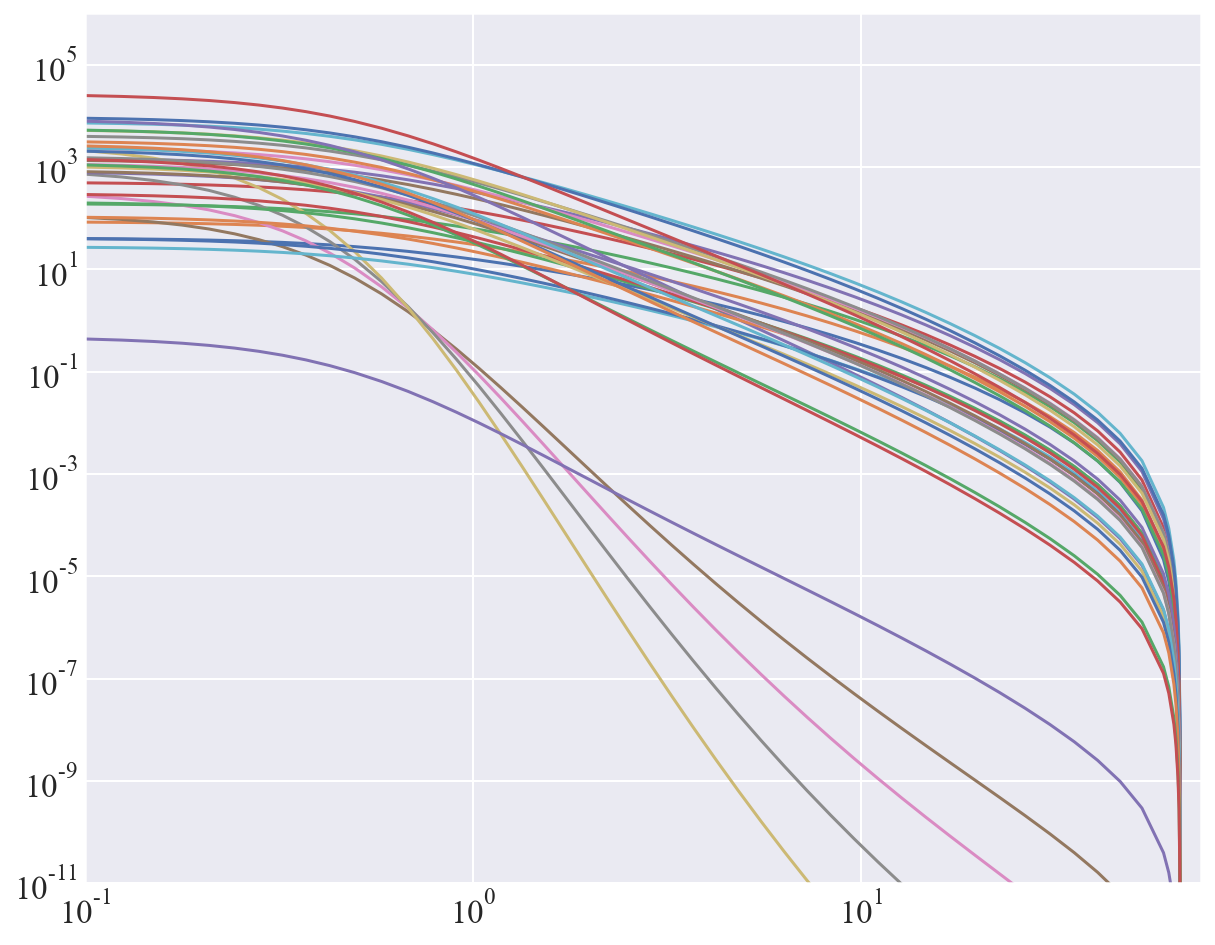

In [13]:
plt.figure()
plt.loglog()
plt.xlim(1e-1, 75)
plt.ylim(1e-11, 1e6)
for i in range(len(model.rhoj)):
    plt.plot(model.r, model.rhoj[i])

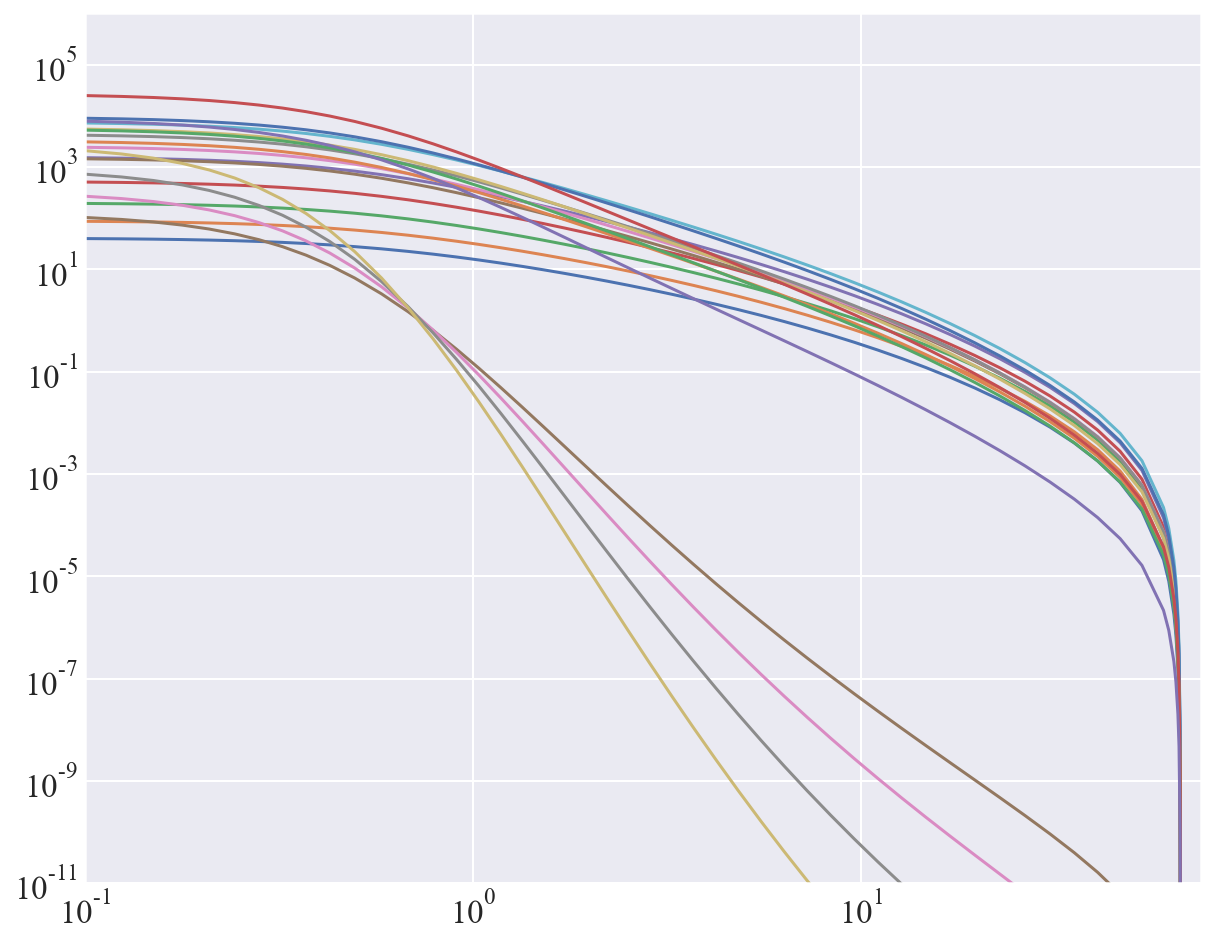

In [14]:
plt.figure()
plt.loglog()
plt.xlim(1e-1, 75)
plt.ylim(1e-11, 1e6)
for i in range(len(model.rescaled_rhoj)):
    plt.plot(model.r, model.rescaled_rhoj[i])

In [15]:
len(model.rhoj)

35

In [16]:
len(model.rescaled_rhoj)

19